In [1]:
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Flatten, Dense, Dropout, Conv1D, MaxPooling1D
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import random
from matplotlib import pyplot as plt
import matplotlib as mpl

2024-07-22 07:25:03.506657: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Replace 'your_file.csv' with the actual filename
filename = 'nasdaq_screener_1704330957680.csv'

# Load the CSV file using pandas
stocks = pd.read_csv(filename)

# Print the loaded data
print(stocks)


     Symbol                                               Name Last Sale  \
0         A             Agilent Technologies Inc. Common Stock   $131.16   
1        AA                    Alcoa Corporation Common Stock     $31.49   
2      AACG   ATA Creativity Global American Depositary Shares     $1.04   
3      AACI            Armada Acquisition Corp. I Common Stock    $10.83   
4     AACIW                 Armada Acquisition Corp. I Warrant    $0.025   
...     ...                                                ...       ...   
7259   ZVRA               Zevra Therapeutics Inc. Common Stock     $6.42   
7260   ZVSA             ZyVersa Therapeutics Inc. Common Stock   $0.9181   
7261    ZWS  Zurn Elkay Water Solutions Corporation Common ...    $28.18   
7262   ZYME                        Zymeworks Inc. Common Stock    $10.67   
7263   ZYXI                            Zynex Inc. Common Stock    $10.61   

      Net Change % Change    Market Cap        Country  IPO Year   Volume  \
0        -

In [5]:
def get_weekday_dates(start_date, end_date):
    weekdays = []
    current_date = start_date
    while current_date <= end_date:
        if current_date.weekday() < 5:  # Monday to Friday (0 to 4)
            weekdays.append(current_date.strftime("%Y-%m-%d"))
        current_date += timedelta(days=1)
    return weekdays

In [6]:
def get_weekday_dates_after(start_date, end_date):
    weekdays = []
    current_date = start_date
    while current_date <= end_date:
        if current_date.weekday() < 5:  # Monday to Friday (0 to 4)
            weekdays.append((current_date+timedelta(days=1)).strftime("%Y-%m-%d"))
        current_date += timedelta(days=1)
    return weekdays

In [7]:
start_date = datetime(2024, 5, 15)  # Start date
end_date = datetime(2024, 6, 30)    # End date
weekday_dates = get_weekday_dates(start_date, end_date)
weekday_dates_after = get_weekday_dates_after(start_date, end_date)


In [9]:
test = yf.download(stocks['Symbol'].iloc[2], start=weekday_dates[1], end=weekday_dates[2], interval='15m')
dtypes = [name for name in test]
test, dtypes

[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['AACG']: Exception('%ticker%: 15m data not available for startTime=1715832000 and endTime=1715918400. The requested range must be within the last 60 days.')


(Empty DataFrame
 Columns: [Open, High, Low, Close, Adj Close, Volume]
 Index: [],
 ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])

In [10]:
# symbols = list(stocks[stocks['Country'] == 'United States']['Symbol'].values[:500])
symbols = list(stocks[stocks['Country'] == 'United States']['Symbol'].values)
intervals = 3
for i in tqdm(range(intervals)):
    if i == 0:
        data = yf.download(symbols[:(i+1)*(len(symbols)//intervals)], start_date, end_date, interval='15m')        
    elif (i+1)*(len(symbols)//intervals) < len(symbols):
        data = pd.concat([data, yf.download(symbols[i*len(symbols)//intervals:(i+1)*(len(symbols)//intervals)], start_date, end_date, interval='15m')], axis=1).sort_index(axis=1)
    else:
        data = pd.concat([data, yf.download(symbols[i*len(symbols)//intervals:], start_date, end_date, interval='15m')], axis=1).sort_index(axis=1)

  0%|          | 0/3 [00:00<?, ?it/s]

[****                   9%%                      ]  166 of 1871 completed

Failed to get ticker 'BRK/B' reason: Expecting value: line 1 column 1 (char 0)


[***********           23%%                      ]  433 of 1871 completed

Failed to get ticker 'BRK/A' reason: Expecting value: line 1 column 1 (char 0)


[*************         27%%                      ]  499 of 1871 completed

Failed to get ticker 'CRD/B' reason: Expecting value: line 1 column 1 (char 0)


[**********************54%%                      ]  1006 of 1871 completed

Failed to get ticker 'CRD/A' reason: Expecting value: line 1 column 1 (char 0)


[**********************59%%**                    ]  1097 of 1871 completed

Failed to get ticker 'BF/A' reason: Expecting value: line 1 column 1 (char 0)


[**********************69%%*******               ]  1283 of 1871 completed

Failed to get ticker 'BF/B' reason: Expecting value: line 1 column 1 (char 0)


[**********************81%%*************         ]  1509 of 1871 completed

Failed to get ticker 'BIO/B' reason: Expecting value: line 1 column 1 (char 0)


[*********************100%%**********************]  1871 of 1871 completed


1871 Failed downloads:
['AGYS', 'CHCO', 'ERNA', 'CRIS', 'BKYI', 'AVXL', 'APPS', 'EW', 'CWST', 'AVNW', 'ATNFW', 'AAOI', 'ARMP', 'AEP', 'ECCV', 'CSL', 'BRACR', 'ATLX', 'ANSCU', 'BTA', 'BEEM', 'CRMD', 'AWRE', 'CNFRZ', 'CTRE', 'ACI', 'AWI', 'AMBA', 'ENS', 'BDJ', 'CHX', 'ACTG', 'BPOPM', 'DDT', 'CETXP', 'ENSV', 'CONXU', 'AOGO', 'EXPE', 'AZO', 'CFBK', 'BHFAO', 'BURL', 'CAT', 'AONCW', 'EVA', 'ARE', 'CRDF', 'CRVS', 'ADUS', 'ELYM', 'ALT', 'CHCI', 'COUR', 'ADBE', 'BFZ', 'EMO', 'ATMV', 'BR', 'DZSI', 'CDZI', 'ADT', 'DXYN', 'CBU', 'CR', 'BHFAL', 'BACK', 'EMCG', 'ACR', 'EME', 'ETON', 'BAFN', 'EVGOW', 'ATLCP', 'BKT', 'CABA', 'BHAC', 'AMRK', 'ESCA', 'ETY', 'EAST', 'CASI', 'AMCX', 'AL', 'AVNT', 'CWT', 'ARRW', 'EB', 'AIN', 'ADTHW', 'BELFA', 'DC', 'CARA', 'EQT', 'BIOR', 'EDR', 'DSGN', 'BHK', 'ESLA', 'CDXS', 'ARC', 'CNK', 'ANGO', 'BAERW', 'COFS', 'CTCX', 'BOCN', 'AE', 'AIZN', 'CXH', 'AMR', 'ANIX', 'DDS', 'BKU', 'DAKT', 'ENVX', 'DEA', 'BOF', 'CDW', 'AIRC', 'A', 'BX', 'COLM', 'DNLI', 'ACXP', 'CNDT', 'CXDO',

 33%|███▎      | 1/3 [04:08<08:17, 248.59s/it]

[******                13%%                      ]  238 of 1871 completed

Failed to get ticker 'HEI/A' reason: Expecting value: line 1 column 1 (char 0)


[**********************61%%***                   ]  1147 of 1871 completed

Failed to get ticker 'HVT/A' reason: Expecting value: line 1 column 1 (char 0)


[*********************100%%**********************]  1871 of 1871 completed


1870 Failed downloads:
['GOOG', 'GECC', 'MEG', 'FGB', 'GSHD', 'LEU', 'KAI', 'MTZ', 'MSBI', 'HESM', 'LCID', 'OGN', 'MEI', 'FR', 'FPAY', 'FLUX', 'FSCO', 'IOT', 'GDO', 'LWLG', 'IDT', 'NTRA', 'JSPRW', 'OLPX', 'HIW', 'IONS', 'LIFWZ', 'LPSN', 'KKRS', 'LBBBR', 'HBNC', 'GNRC', 'GHIXU', 'GFS', 'KTH', 'IROQ', 'LUCY', 'HWKN', 'OLB', 'MRTN', 'IGC', 'GNT', 'FDMT', 'GLV', 'HTIBP', 'GLSTW', 'ISSC', 'GNW', 'HGTY', 'GBAB', 'KRC', 'NRBO', 'LVWR', 'MYN', 'LTRN', 'LGL', 'LEO', 'MMLP', 'LRCX', 'FMBH', 'NPK', 'GERN', 'LANDM', 'LIFWW', 'MCACR', 'FTV', 'ODFL', 'HTLD', 'MTTR', 'NCPLW', 'FMNB', 'NUW', 'HNNA', 'OFLX', 'IBOC', 'IP', 'HYMC', 'HSPOW', 'HUMA', 'LNTH', 'HOWL', 'MBINO', 'LVO', 'IPX', 'HPP', 'MAQC', 'GRF', 'HZO', 'KITTW', 'LGMK', 'GIII', 'HFRO', 'NUV', 'IVAC', 'KMPB', 'INFU', 'HXL', 'MBCN', 'HEPA', 'MPC', 'HUBB', 'FULC', 'NDSN', 'NUTX', 'MEDP', 'GCO', 'FVCB', 'GWRE', 'HURN', 'MYRG', 'IDA', 'NYMT', 'MMU', 'ODP', 'LKQ', 'NZF', 'JNPR', 'MSGS', 'ISRG', 'IIM', 'MLR', 'FHTX', 'LFVN', 'GATO', 'IIIV', 'LEN', 

 67%|██████▋   | 2/3 [08:19<04:09, 249.98s/it]

[**********************62%%****                  ]  1153 of 1870 completed

Failed to get ticker 'WSO/B' reason: Expecting value: line 1 column 1 (char 0)


[*********************100%%**********************]  1870 of 1870 completed


1870 Failed downloads:
['WINVR', 'SBUX', 'PAYO', 'SKIN', 'SCOR', 'XPRO', 'PFC', 'WGO', 'TCI', 'PD', 'SRM', 'PUMP', 'UBX', 'RILYP', 'OTLK', 'XLO', 'XMTR', 'PAY', 'SM', 'PINE', 'VTR', 'ZTS', 'RDZN', 'PTGX', 'VCSA', 'SNPO', 'TLYS', 'SRZNW', 'PLPC', 'VLT', 'PIK', 'TNGX', 'PWUPU', 'PFD', 'ZIMV', 'TGI', 'RGTI', 'SNES', 'SUPN', 'STE', 'VSACW', 'SFM', 'PKST', 'WMS', 'RWAY', 'SEER', 'WHG', 'YUM', 'PBH', 'QVCC', 'PINC', 'VECO', 'TRI', 'QOMO', 'RENB', 'TDG', 'SHPWW', 'PTWO', 'PNNT', 'TBBK', 'TRONU', 'YOTAW', 'WTRG', 'RNA', 'SRRK', 'VRCA', 'PDM', 'WRBY', 'TGNA', 'SMHI', 'OXLCM', 'RVMDW', 'UMBF', 'SPRY', 'PSMT', 'RDZNW', 'VLY', 'PCYO', 'SEB', 'SEEL', 'OMIC', 'ORIC', 'SCI', 'UHG', 'SFNC', 'SOFI', 'WELL', 'OPY', 'VERY', 'PEBO', 'SWN', 'SSIC', 'VEEE', 'STRT', 'PHT', 'OUT', 'PRPO', 'RUSHA', 'UNFI', 'STIXW', 'POST', 'TURN', 'POLA', 'TUP', 'TWN', 'PTWOU', 'VLD', 'SCLXW', 'TMTCR', 'TRDA', 'WSBF', 'VRPX', 'VGZ', 'VSTS', 'PLAY', 'RILY', 'USGO', 'SEMR', 'RNXT', 'TPST', 'PANW', 'W', 'SHBI', 'VVOS', 'VRNT', '

100%|██████████| 3/3 [12:36<00:00, 252.13s/it]


In [13]:
dates = np.unique([i.date() for i in data['Open'].index])

In [17]:
full_dataset = [True if np.isnan(data[name]).sum() == 0 else False for name in data.columns]

In [19]:
data = data[data.columns[full_dataset]]

In [23]:
binary_model = Sequential()

# binary_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(int(data.shape[0]/dates.size), n_features)))
binary_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(int(data.shape[0]/dates.size), n_features)))
binary_model.add(MaxPooling1D(pool_size=2))
binary_model.add(Dropout(0.2))

# You can add more CNN layers if needed
binary_model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
binary_model.add(MaxPooling1D(pool_size=2))
binary_model.add(Dropout(0.2))

# Flatten the output of the CNN
binary_model.add(Flatten())

# Add the LSTM layer
binary_model.add(tf.keras.layers.Reshape((-1, 128)))


# binary_model.add(LSTM(50, input_shape=(int(data.shape[0]/dates.size), n_features)))
binary_model.add(LSTM(50))
# model.add(Dropout(rate=0.2))
# model.add(Dense(units=64, activation='relu'))
# model.add(Dropout(rate=0.2))
# model.add(Dense(units=32, activation='relu'))
# model.add(Dropout(rate=0.2))
# model.add(Dense(units=16, activation='relu'))
# model.add(Dropout(rate=0.2))

# Output layer with a single unit (assuming a regression problem)
binary_model.add(Dense(1, activation='sigmoid'))
# binary_model.add(Dense(1, activation='softmax'))

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-1,
#     decay_steps=10000,
#     decay_rate=0.9)
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
# # Compile the model with an appropriate loss function and optimizer
# binary_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
binary_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# binary_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model's architecture
binary_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 24, 64)            1216      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 12, 64)            0         
 g1D)                                                            
                                                                 
 dropout (Dropout)           (None, 12, 64)            0         
                                                                 
 conv1d_4 (Conv1D)           (None, 10, 128)           24704     
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 5, 128)            0         
 g1D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 5, 128)           

In [24]:
pred_model = Sequential()

pred_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(int(data.shape[0]/dates.size), n_features)))
pred_model.add(MaxPooling1D(pool_size=2))
pred_model.add(Dropout(0.2))

# You can add more CNN layers if needed
pred_model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
pred_model.add(MaxPooling1D(pool_size=2))
pred_model.add(Dropout(0.2))

# Flatten the output of the CNN
pred_model.add(tf.keras.layers.Reshape((-1, 128)))

# pred_model.add(LSTM(50, input_shape=(int(data.shape[0]/dates.size), n_features)))
pred_model.add(LSTM(50))

# Output layer with a single unit (assuming a regression problem)
pred_model.add(Dense(1))

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-1,
#     decay_steps=10000,
#     decay_rate=0.9)
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
# # Compile the model with an appropriate loss function and optimizer
# pred_model.compile(optimizer=optimizer, loss='mean_squared_error')
pred_model.compile(optimizer='adam', loss='mean_squared_error')

# Print a summary of the model's architecture
pred_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 24, 64)            1216      
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 12, 64)            0         
 g1D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 12, 64)            0         
                                                                 
 conv1d_6 (Conv1D)           (None, 10, 128)           24704     
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 5, 128)            0         
 g1D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 5, 128)           

In [25]:
dates_mask = [[True if i.date() == date else False for i in data.index] for date in dates]

In [28]:
features = np.unique([i[0] for i in data.columns])
features

array(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='<U9')

In [29]:
symbols = np.unique([i[1] for i in data.columns])
symbols

array(['A', 'AA', 'AAL', ..., 'ZM', 'ZOM', 'ZS'], dtype='<U5')

In [31]:
raw_data = [[[data[(feature, symbol)][dates_mask[i]].values for symbol in symbols] for feature in features] for i in range(len(dates))]

In [32]:
raw_data = np.array(raw_data)

In [35]:
raw_data = np.swapaxes(raw_data, 1, 2)
raw_data = np.swapaxes(raw_data, 2, 3)
raw_data.shape

(31, 1695, 26, 6)

In [39]:
raw_data = raw_data[:, :, :, 1:5]
raw_data.shape

(31, 1695, 26, 4)

In [40]:
features = features[1:5]
features

array(['Close', 'High', 'Low', 'Open'], dtype='<U9')

In [41]:
raw_data = np.concatenate((raw_data, 
                           np.array(raw_data[:, :, :, 0] - raw_data[:, :, :, 3]).reshape(raw_data.shape[0], raw_data.shape[1], raw_data.shape[2], 1)), axis=3)

In [42]:
raw_data = np.concatenate((raw_data, 
                           np.array(raw_data[:, :, :, 1] - raw_data[:, :, :, 2]).reshape(raw_data.shape[0], raw_data.shape[1], raw_data.shape[2], 1)), axis=3)

In [43]:
raw_data.shape

(31, 1695, 26, 6)

In [45]:
opens0 = raw_data[:, :, 0, 3]
opens1 = raw_data[:, :, 1, 3]
opens2 = raw_data[:, :, 2, 3]
opens3 = raw_data[:, :, 3, 3]
close0 = raw_data[:, :, 0, 3]
close1 = raw_data[:, :, 1, 3]
close2 = raw_data[:, :, 2, 3]
close3 = raw_data[:, :, 3, 3]
highs0 = raw_data[:, :, 0, 3]
highs1 = raw_data[:, :, 1, 3]
highs2 = raw_data[:, :, 2, 3]
highs3 = raw_data[:, :, 3, 3]
lows0 = raw_data[:, :, 0, 3]
lows1 = raw_data[:, :, 1, 3]
lows2 = raw_data[:, :, 2, 3]
lows3 = raw_data[:, :, 3, 3]

In [46]:
data.shape

(806, 10170)

In [52]:
pred_targets = np.divide((opens0[2:] - opens0[1:-1]), opens0[1:-1])
pred_targets.shape

(29, 1695)

In [54]:
pred_targets = pred_targets.reshape(pred_targets.shape[0]*pred_targets.shape[1])

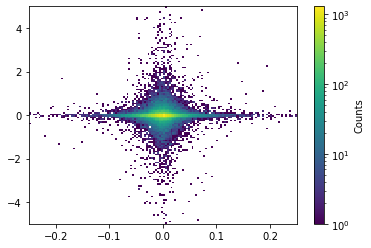

In [57]:
fig, ax = plt.subplots()
# im = ax.hist2d(pred_targets, raw_data[:-2, :, :, 5], bins=np.linspace(-70, 70, 141), cmap='viridis', norm=mpl.colors.LogNorm())
im = ax.hist2d(pred_targets, raw_data[:-2, :, 4, 4].flatten(), bins=[np.linspace(-0.25, 0.25, 141), np.linspace(-5, 5, 141)], cmap='viridis', norm=mpl.colors.LogNorm())
cbar = fig.colorbar(im[3], ax=ax)
cbar.set_label('Counts')

In [66]:
cond_good = np.full(raw_data[2:].shape[:2], True, dtype=bool)
for i in range(4):
    # for j in range(4):
    for j in range(1, 4):
        # cond &= np.divide((raw_data[2:, :, i, j] - raw_data[1:-1, :, i, j]), raw_data[1:-1, :, i, j]) > 0.01
        cond_good &= np.divide((raw_data[2:, :, i, j] - raw_data[1:-1, :, i, j]), raw_data[1:-1, :, i, j]) > 0.04

In [69]:
cond_good = cond_good.reshape(cond_good.shape[0]*cond_good.shape[1])

In [70]:
# binary_targets = np.array([1 if i > 0 else 0 for i in pred_targets])
binary_targets = np.array([1 if i == True else 0 for i in cond_good])

In [71]:
binary_targets.shape

(49155,)

In [72]:
cond_okay = np.full(raw_data[2:].shape[:2], True, dtype=bool)
for i in range(4):
    # for j in range(4):
    for j in range(1, 4):
        # cond &= np.divide((raw_data[2:, :, i, j] - raw_data[1:-1, :, i, j]), raw_data[1:-1, :, i, j]) > 0.01
        cond_okay &= np.divide((raw_data[2:, :, i, j] - raw_data[1:-1, :, i, j]), raw_data[1:-1, :, i, j]) > 0
print(raw_data[2:][cond_okay].size/raw_data[2:].size)
cond_okay = cond_okay.reshape(cond_okay.shape[0]*cond_okay.shape[1])

0.26855864103346555


In [73]:
cond_bad = np.full(raw_data[2:].shape[:2], True, dtype=bool)
for i in range(4):
    # for j in range(4):
    for j in range(1, 4):
        # cond &= np.divide((raw_data[2:, :, i, j] - raw_data[1:-1, :, i, j]), raw_data[1:-1, :, i, j]) > 0.01
        cond_bad &= np.divide((raw_data[2:, :, i, j] - raw_data[1:-1, :, i, j]), raw_data[1:-1, :, i, j]) < -0.01
print(raw_data[2:][cond_bad].size/raw_data[2:].size)
cond_bad = cond_bad.reshape(cond_bad.shape[0]*cond_bad.shape[1])

0.15955650493337403


In [74]:
# binary_targets = np.array([1 if i > 0 else 0 for i in pred_targets])
binary_targets_okay = np.array([1 if i == True else 0 for i in cond_okay])

In [92]:
counts = np.full(raw_data[2:].shape[0]*raw_data.shape[1], 0, dtype=int)
for i in range(4):
    # counts = np.add(counts, np.divide((raw_data[2:, :, -1, i] - raw_data[1:-1, :, 0, i]), raw_data[1:-1, :, 0, i]).flatten())
    counts = np.add(counts, np.divide((raw_data[:-2, :, -1, i] - raw_data[:-2, :, 0, i]), raw_data[:-2, :, 0, i]).flatten())

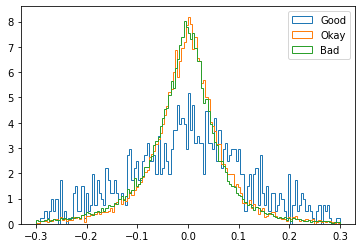

In [93]:
fig, ax = plt.subplots()
ax.hist(counts[cond_good], bins=np.linspace(-0.3, 0.3, 141), histtype='step', density=True, label='Good')
ax.hist(counts[cond_okay], bins=np.linspace(-0.3, 0.3, 141), histtype='step', density=True, label='Okay')
ax.hist(counts[~cond_okay], bins=np.linspace(-0.3, 0.3, 141), histtype='step', density=True, label='Bad')
ax.legend()

In [94]:
counts = np.full(raw_data[2:].shape[0]*raw_data.shape[1], 0, dtype=int)
for i in range(4):
    for j in range(4):
        # counts = np.add(counts, np.divide((raw_data[2:, :, -(i+1), j] - raw_data[1:-1, :, i, j]), raw_data[1:-1, :, i, j]).flatten())
        counts = np.add(counts, np.divide((raw_data[:-2, :, -(i+1), j] - raw_data[:-2, :, i, j]), raw_data[:-2, :, i, j]).flatten())

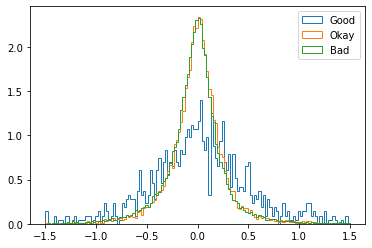

In [95]:
fig, ax = plt.subplots()
ax.hist(counts[cond_good], bins=np.linspace(-1.5, 1.5, 141), histtype='step', density=True, label='Good')
ax.hist(counts[cond_okay], bins=np.linspace(-1.5, 1.5, 141), histtype='step', density=True, label='Okay')
ax.hist(counts[~cond_okay], bins=np.linspace(-1.5, 1.5, 141), histtype='step', density=True, label='Bad')
ax.legend()

In [87]:
counts = np.full(raw_data[2:].shape[0]*raw_data.shape[1], 0, dtype=int)
for i in range(4):
    for j in range(4):
        counts = np.add(counts, np.divide((raw_data[2:, :, -(i+1), j] - raw_data[1:-1, :, i, j]), raw_data[1:-1, :, i, j]).flatten())
        # counts = np.add(counts, np.divide((raw_data[2:, :, -(i+1), j] - raw_data[2:, :, i, j]), raw_data[2:, :, i, j]).flatten())

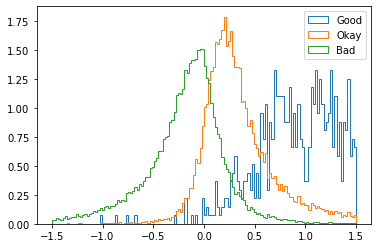

In [89]:
fig, ax = plt.subplots()
ax.hist(counts[cond_good], bins=np.linspace(-1.5, 1.5, 141), histtype='step', density=True, label='Good')
ax.hist(counts[cond_okay], bins=np.linspace(-1.5, 1.5, 141), histtype='step', density=True, label='Okay')
ax.hist(counts[~cond_okay], bins=np.linspace(-1.5, 1.5, 141), histtype='step', density=True, label='Bad')
ax.legend()

In [90]:
counts = np.full(raw_data[2:].shape[0]*raw_data.shape[1], 0, dtype=int)
for i in range(4):
    for j in range(4):
        counts = np.add(counts, np.divide((raw_data[2:, :, -(i+1), j] - raw_data[:-2, :, i, j]), raw_data[:-2, :, i, j]).flatten())
        # counts = np.add(counts, np.divide((raw_data[2:, :, -(i+1), j] - raw_data[2:, :, i, j]), raw_data[2:, :, i, j]).flatten())

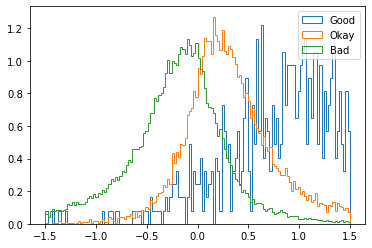

In [91]:
fig, ax = plt.subplots()
ax.hist(counts[cond_good], bins=np.linspace(-1.5, 1.5, 141), histtype='step', density=True, label='Good')
ax.hist(counts[cond_okay], bins=np.linspace(-1.5, 1.5, 141), histtype='step', density=True, label='Okay')
ax.hist(counts[~cond_okay], bins=np.linspace(-1.5, 1.5, 141), histtype='step', density=True, label='Bad')
ax.legend()

In [80]:
raw_data = raw_data[:-2]

In [83]:
raw_data = raw_data.reshape(raw_data.shape[0]*raw_data.shape[1], raw_data.shape[2], raw_data.shape[3])

In [89]:
balance_mask = random.sample(list(np.where(binary_targets == 0)[0]), binary_targets[binary_targets == 0].shape[0] - binary_targets[binary_targets == 1].shape[0])

In [90]:
balance_mask = [False if i in balance_mask else True for i in range(binary_targets.shape[0])]

In [91]:
raw_data_balance = raw_data[balance_mask]
binary_targets_balance = binary_targets[balance_mask]
pred_targets_balance = pred_targets[balance_mask]

In [92]:
# binary_targets = binary_targets.ravel()
binary_targets_balance = binary_targets_balance.reshape(-1, 1)

# pred_targets = pred_targets.ravel()
pred_targets_balance = pred_targets_balance.reshape(-1, 1)

In [96]:
from sklearn.model_selection import train_test_split

# Assuming 'data' is your input feature matrix and 'targets' is your output values
X_train, X_test, y_train_pred, y_test_pred = train_test_split(raw_data_balance, pred_targets_balance, test_size=0.2, random_state=42)
X_train, X_test, y_train_binary, y_test_binary = train_test_split(raw_data_balance, binary_targets_balance, test_size=0.2, random_state=42)
# X_train_2, X_test_2, y_train_binary, y_test_binary = train_test_split(raw_data[:, :-2, -2], binary_targets, test_size=0.2, random_state=42)

In [99]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_binary), y=y_train_binary.T[0])
class_weights = dict(enumerate(class_weights))

In [100]:
class_weights

{0: 1.0024271844660195, 1: 0.9975845410628019}

In [118]:
# Train the model
pred_model.fit(X_train, y_train_pred, epochs=50, batch_size=20, verbose=2)

Epoch 1/50
1831/1831 - 12s - loss: 0.0469 - 12s/epoch - 6ms/step
Epoch 2/50
1831/1831 - 9s - loss: 0.0459 - 9s/epoch - 5ms/step
Epoch 3/50
1831/1831 - 9s - loss: 0.0457 - 9s/epoch - 5ms/step
Epoch 4/50
1831/1831 - 10s - loss: 0.0455 - 10s/epoch - 5ms/step
Epoch 5/50
1831/1831 - 8s - loss: 0.0455 - 8s/epoch - 4ms/step
Epoch 6/50
1831/1831 - 8s - loss: 0.0457 - 8s/epoch - 4ms/step
Epoch 7/50
1831/1831 - 8s - loss: 0.0456 - 8s/epoch - 4ms/step
Epoch 8/50
1831/1831 - 9s - loss: 0.0457 - 9s/epoch - 5ms/step
Epoch 9/50
1831/1831 - 10s - loss: 0.0456 - 10s/epoch - 5ms/step
Epoch 10/50
1831/1831 - 9s - loss: 0.0456 - 9s/epoch - 5ms/step
Epoch 11/50
1831/1831 - 8s - loss: 0.0455 - 8s/epoch - 4ms/step
Epoch 12/50
1831/1831 - 8s - loss: 0.0454 - 8s/epoch - 4ms/step
Epoch 13/50
1831/1831 - 8s - loss: 0.0457 - 8s/epoch - 4ms/step
Epoch 14/50
1831/1831 - 9s - loss: 0.0456 - 9s/epoch - 5ms/step
Epoch 15/50
1831/1831 - 9s - loss: 0.0455 - 9s/epoch - 5ms/step
Epoch 16/50
1831/1831 - 9s - loss: 0.0455 -

In [105]:
# Train the model
binary_model.fit(X_train, y_train_binary, epochs=50, batch_size=20, verbose=2)
# binary_model.fit(X_train, y_train_binary, epochs=50, batch_size=20, verbose=2, class_weight=class_weights)

Epoch 1/50


83/83 - 0s - loss: 0.5627 - accuracy: 0.7185 - 344ms/epoch - 4ms/step
Epoch 2/50
83/83 - 0s - loss: 0.5627 - accuracy: 0.7252 - 353ms/epoch - 4ms/step
Epoch 3/50
83/83 - 0s - loss: 0.5593 - accuracy: 0.7276 - 445ms/epoch - 5ms/step
Epoch 4/50
83/83 - 0s - loss: 0.5583 - accuracy: 0.7288 - 366ms/epoch - 4ms/step
Epoch 5/50
83/83 - 0s - loss: 0.5589 - accuracy: 0.7203 - 314ms/epoch - 4ms/step
Epoch 6/50
83/83 - 0s - loss: 0.5654 - accuracy: 0.7161 - 328ms/epoch - 4ms/step
Epoch 7/50
83/83 - 0s - loss: 0.5612 - accuracy: 0.7228 - 308ms/epoch - 4ms/step
Epoch 8/50
83/83 - 0s - loss: 0.5562 - accuracy: 0.7343 - 307ms/epoch - 4ms/step
Epoch 9/50
83/83 - 0s - loss: 0.5613 - accuracy: 0.7149 - 308ms/epoch - 4ms/step
Epoch 10/50
83/83 - 0s - loss: 0.5575 - accuracy: 0.7282 - 308ms/epoch - 4ms/step
Epoch 11/50
83/83 - 0s - loss: 0.5531 - accuracy: 0.7246 - 300ms/epoch - 4ms/step
Epoch 12/50
83/83 - 0s - loss: 0.5543 - accuracy: 0.7264 - 303ms/epoch - 4ms/step
Epoch 13/50
83/83 - 0s - loss: 0.557

In [504]:
binary_model.save('models/binary_model_1695stocks_31days_4percent_2024_07_05.keras')

In [119]:
# Get predictions for the test data
y_pred = pred_model.predict(X_test)

287/287 [==============================] - 2s 4ms/step


In [107]:
# Get predictions for the test data
y_binary = binary_model.predict(X_test)

13/13 [==============================] - 0s 4ms/step


In [103]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_auc_score

In [87]:
## Even balance -- 2D CNN to 1D LSTM -- Remove stocks with any Nans -- May 15 - June 30, 2024
mae = mean_absolute_error(y_test_pred, y_pred)
mae

0.022534755795168636

In [120]:
## Even balance -- 2D CNN to 1D LSTM -- 6 Features (Open, Close, High, Low, High-Low, Open-Close) -- Remove stocks with any Nans -- May 15 - June 30, 2024
mae = mean_absolute_error(y_test_pred, y_pred)
mae

0.03672027807127693

In [66]:
## Even balance -- 2D CNN to 1D LSTM -- Remove stocks with any Nans -- May 15 - June 30, 2024
auc_score = roc_auc_score(y_test_binary, y_binary)
auc_score

0.5282800233317312

In [117]:
## Even balance -- 2D CNN to 1D LSTM -- 6 Features (Open, Close, High, Low, High-Low, Open-Close) -- Remove stocks with any Nans -- May 15 - June 30, 2024
auc_score = roc_auc_score(y_test_binary, y_binary)
auc_score

0.5237086738494151

In [426]:
## Strict binary classifier, first four features > 1 percent gain over first hour -- 2D CNN to 1D LSTM -- 6 Features (Open, Close, High, Low, High-Low, Open-Close) -- Remove stocks with any Nans -- May 15 - June 30, 2024
auc_score = roc_auc_score(y_test_binary, y_binary)
auc_score

0.5573656401850008

In [501]:
## Strict binary classifier, first four features > 2 percent gain over first hour -- 2D CNN to 1D LSTM -- 6 Features (Open, Close, High, Low, High-Low, Open-Close) -- Remove stocks with any Nans -- May 15 - June 30, 2024
auc_score = roc_auc_score(y_test_binary, y_binary)
auc_score

0.6491329299967339

In [572]:
## Strict binary classifier, first four features > 3 percent gain over first hour -- 2D CNN to 1D LSTM -- 6 Features (Open, Close, High, Low, High-Low, Open-Close) -- Remove stocks with any Nans -- May 15 - June 30, 2024
auc_score = roc_auc_score(y_test_binary, y_binary)
auc_score

0.6860775845067645

In [251]:
## Strict binary classifier, first four features > 5 percent gain over first hour -- 2D CNN to 1D LSTM -- 6 Features (Open, Close, High, Low, High-Low, Open-Close) -- Remove stocks with any Nans -- May 15 - June 30, 2024
auc_score = roc_auc_score(y_test_binary, y_binary)
auc_score

0.8357117584620828

In [498]:
## Strict binary classifier, first four features > 4 percent gain over first hour -- 2D CNN to 1D LSTM -- 6 Features (Open, Close, High, Low, High-Low, Open-Close) -- Remove stocks with any Nans -- May 15 - June 30, 2024
auc_score = roc_auc_score(y_test_binary, y_binary)
auc_score

0.8383753501400562

In [108]:
## Strict binary classifier, first four features > 4 percent gain over first hour -- 2D CNN to 1D LSTM -- 6 Features (Open, Close, High, Low, High-Low, Open-Close) -- Remove stocks with any Nans -- May 15 - June 30, 2024
auc_score = roc_auc_score(y_test_binary, y_binary)
auc_score

0.7759131753996966

In [109]:
## Strict binary classifier, first four features > 4 percent gain over first hour -- 2D CNN to 1D LSTM -- 6 Features (Open, Close, High, Low, High-Low, Open-Close) -- Remove stocks with any Nans -- May 15 - June 30, 2024
# Get predictions for the test data
y_binary_all = binary_model.predict(raw_data)
auc_score = roc_auc_score(binary_targets, y_binary_all)
auc_score

1537/1537 [==============================] - 3s 2ms/step


0.8057986732897706

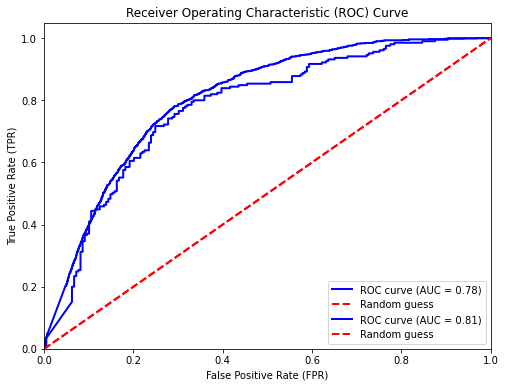

In [110]:
from sklearn.metrics import roc_curve, auc

# Assuming y_true and y_pred are the true binary labels and predicted probabilities, respectively

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_binary, y_binary)

# Compute AUC score
auc_score = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Random guess')

fpr, tpr, thresholds = roc_curve(binary_targets, y_binary_all)
auc_score = auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
